# Data Engineering

## Import

In [ ]:
import os
import numpy as np
import cv2
from zipfile import ZipFile
import shutil
from sklearn.model_selection import train_test_split

## Data

load data function

In [ ]:
# 폴더로부터 이미지를 불러온다.
def image_load(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            if "climb" == label:
                labels.append(1)
            else:
                labels.append(0)
    return images, labels

True(Climb)

In [ ]:
climb_images, climb_labels = image_load("/content/drive/MyDrive/BabyProject/CV_img_data/True/true_set", "climb")
#471

False(not Climb)

In [ ]:
not_climb_images, not_climb_labels = image_load("/content/drive/MyDrive/BabyProject/datas/fasle", "not climb")
#459

In [ ]:
# climb 데이터와 not climb 데이터를 합치기
images = climb_images + not_climb_images
labels = climb_labels + not_climb_labels

## 이미지 resize

In [ ]:
def resize_images(images, target_size=(224, 224)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

# 이미지 크기 조정
resized_images = resize_images(images)

# NumPy 배열로 변환
labels = np.array(labels)

# 데이터셋 분할 (훈련용:검증용:테스트용 = 0.7:0.15:0.15)
train_images, test_images, train_labels, test_labels = train_test_split(resized_images, labels, test_size=0.3, random_state=42, stratify=labels)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42, stratify=test_labels)

# 데이터셋 크기 확인
print("전체 데이터셋 크기:",resized_images.shape)
print("훈련용 데이터셋 크기:", train_images.shape)
print("검증용 데이터셋 크기:", val_images.shape)
print("테스트용 데이터셋 크기:", test_images.shape)

전체 데이터셋 크기: (930, 224, 224, 3)
훈련용 데이터셋 크기: (651, 224, 224, 3)
검증용 데이터셋 크기: (139, 224, 224, 3)
테스트용 데이터셋 크기: (140, 224, 224, 3)


# Preprocessing

Augument - flip Data

In [ ]:
def augment_images_and_labels(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels): #label과 이미지 증강 함꼐 처리해야 섞이지 않음
        augmented_images.append(img)  # 원본 이미지 추가
        augmented_labels.append(label)

        flipped_img = cv2.flip(img, 1)  # 좌우 반전 이미지 추가
        augmented_images.append(flipped_img)
        augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)

In [ ]:
train_aug_images, train_aug_labels = augment_images_and_labels(train_images, train_labels)
test_aug_images, test_aug_labels = augment_images_and_labels(test_images, test_labels)
val_aug_images, val_aug_labels = augment_images_and_labels(val_images, val_labels)

In [ ]:
# 데이터셋 크기 확인 #이미지 개수 2배 증강됨
print("훈련용 데이터셋 크기:", train_aug_images.shape)
print("검증용 데이터셋 크기:", val_aug_images.shape)
print("테스트용 데이터셋 크기:", test_aug_images.shape)

훈련용 데이터셋 크기: (1302, 224, 224, 3)
검증용 데이터셋 크기: (278, 224, 224, 3)
테스트용 데이터셋 크기: (280, 224, 224, 3)


CannyEdge

기본 전처리

In [ ]:
# 이미지 전처리 함수 정의
def preprocess_images(images):
    # 이미지 크기 조정
    resized_images = resize_images(images)
    # VGG16 모델에 맞게 입력 이미지 전처리
    preprocessed_images = preprocess_input(resized_images)
    return preprocessed_images

# 이미지 전처리
train_images_preprocessed = preprocess_images(train_images)
val_images_preprocessed = preprocess_images(val_images)
test_images_preprocessed = preprocess_images(test_images)

# Model

## Import

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Sat May 18 03:08:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              30W /  70W |   8315MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping

## Pretrained

### 원본 이미지

In [ ]:

# VGG16 모델 불러오기
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 분류층 추가
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# 전체 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# VGG16의 가중치는 고정시키고 새로 추가한 층만 훈련
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#early stopping 도입
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련
history = model.fit(train_images, train_labels,
                    batch_size=32, epochs=20,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping]
                    )

# 모델 평가
loss, accuracy = model.evaluate(test_images, test_labels)
print("테스트 데이터셋에서의 손실:", loss)
print("테스트 데이터셋에서의 정확도:", accuracy)

Epoch 1/20
21/21 [==============================] - 5s 165ms/step - loss: 1.4239 - accuracy: 0.9462 - val_loss: 2.1006 - val_accuracy: 0.9928
Epoch 2/20
21/21 [==============================] - 3s 151ms/step - loss: 0.0804 - accuracy: 0.9969 - val_loss: 1.4122 - val_accuracy: 0.9712
Epoch 3/20
21/21 [==============================] - 3s 144ms/step - loss: 0.1668 - accuracy: 0.9939 - val_loss: 3.1645 - val_accuracy: 0.9928
Epoch 4/20
21/21 [==============================] - 3s 144ms/step - loss: 0.3133 - accuracy: 0.9969 - val_loss: 1.7063 - val_accuracy: 0.9928
Epoch 5/20
21/21 [==============================] - 3s 150ms/step - loss: 0.0212 - accuracy: 0.9985 - val_loss: 2.6695 - val_accuracy: 0.9928
Epoch 6/20
21/21 [==============================] - 3s 150ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.9303 - val_accuracy: 0.9928
Epoch 7/20
5/5 [==============================] - 1s 107ms/step - loss: 0.4422 - accuracy: 0.9857
테스트 데이터셋에서의 손실: 0.4422186613082886
테스트 데이터셋에서의

In [ ]:
# 모델 예측
predictions = model.predict(test_images)
# 확률을 이진 클래스로 변환
predictions_binary = np.where(predictions > 0.5, 1, 0)

# 정밀도, 재현율, F1 스코어 계산
precision = precision_score(test_labels, predictions_binary)
recall = recall_score(test_labels, predictions_binary)
f1 = f1_score(test_labels, predictions_binary)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 스코어:", f1)

#혼동 행렬 생성
cm = confusion_matrix(test_labels,  predictions_binary)
# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

5/5 [==============================] - 1s 126ms/step
정밀도: 1.0
재현율: 0.971830985915493
F1 스코어: 0.9857142857142858
Confusion Matrix:
[[69  0]
 [ 2 69]]


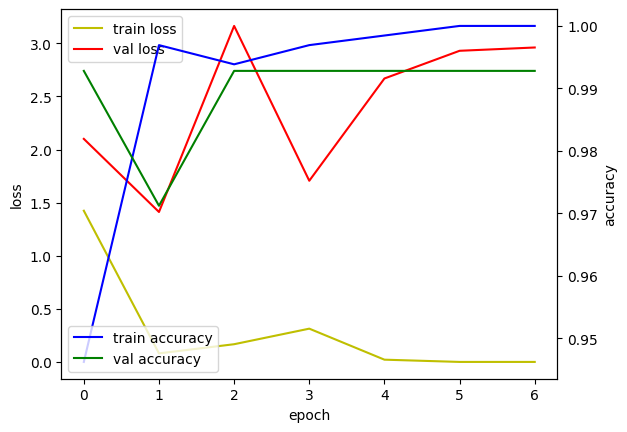

In [ ]:
# 학습 과정
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

### 이미지 증강처리, 원본 이미지

In [ ]:

# VGG16 모델 불러오기
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 분류층 추가
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# 전체 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# VGG16의 가중치는 고정시키고 새로 추가한 층만 훈련
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#early stopping 도입
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련
history = model.fit(train_aug_images, train_aug_labels,
                    batch_size=32, epochs=20,
                    validation_data=(val_aug_images, val_aug_labels),
                    callbacks=[early_stopping])

# 모델 평가
loss, accuracy = model.evaluate(test_aug_images, test_aug_labels)
print("테스트 데이터셋에서의 손실:", loss)
print("테스트 데이터셋에서의 정확도:", accuracy)

Epoch 1/20
41/41 [==============================] - 9s 184ms/step - loss: 1.8744 - accuracy: 0.9624 - val_loss: 0.5911 - val_accuracy: 0.9928
Epoch 2/20
41/41 [==============================] - 6s 156ms/step - loss: 0.0352 - accuracy: 0.9985 - val_loss: 0.2888 - val_accuracy: 0.9856
Epoch 3/20
41/41 [==============================] - 6s 154ms/step - loss: 4.2281e-04 - accuracy: 1.0000 - val_loss: 0.3545 - val_accuracy: 0.9856
Epoch 4/20
41/41 [==============================] - 6s 149ms/step - loss: 4.4061e-16 - accuracy: 1.0000 - val_loss: 0.3569 - val_accuracy: 0.9856
Epoch 5/20
41/41 [==============================] - 6s 153ms/step - loss: 4.2281e-16 - accuracy: 1.0000 - val_loss: 0.3569 - val_accuracy: 0.9856
Epoch 6/20
41/41 [==============================] - 6s 154ms/step - loss: 4.2259e-16 - accuracy: 1.0000 - val_loss: 0.3569 - val_accuracy: 0.9856
Epoch 7/20
9/9 [==============================] - 1s 122ms/step - loss: 0.2476 - accuracy: 0.9929
테스트 데이터셋에서의 손실: 0.2476018965244293

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 모델 예측
predictions = model.predict(test_aug_images)
# 확률을 이진 클래스로 변환
predictions_binary = np.where(predictions > 0.5, 1, 0)

# 정밀도, 재현율, F1 스코어 계산
precision = precision_score(test_aug_labels, predictions_binary)
recall = recall_score(test_aug_labels, predictions_binary)
f1 = f1_score(test_aug_labels, predictions_binary)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 스코어:", f1)


#혼동 행렬 생성
cm = confusion_matrix(test_aug_labels,  predictions_binary)
# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

9/9 [==============================] - 1s 120ms/step
정밀도: 0.9861111111111112
재현율: 1.0
F1 스코어: 0.993006993006993
Confusion Matrix:
[[136   2]
 [  0 142]]


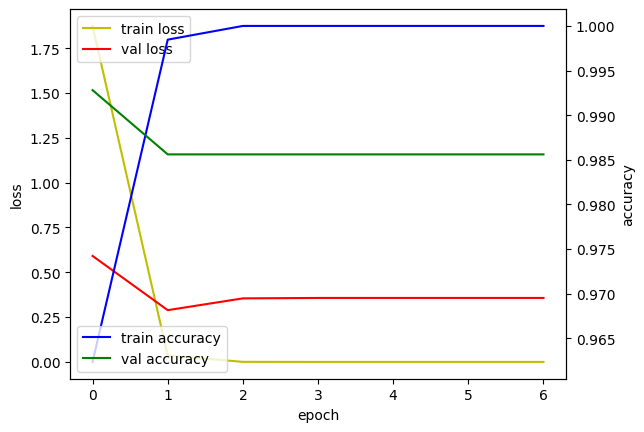

In [ ]:
# 학습 과정
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

#Build Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 모델 생성
model = Sequential()

# Convolutional Layer와 Pooling Layer 추가
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fully Connected Layer 추가
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 구조 출력
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

## Plot Func

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 손실 시각화
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 훈련 및 검증 정확도 시각화
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 훈련 손실, 정확도 전체 시각화
def plot_hist(history):
  # 학습 과정
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()

  loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
  loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')

  acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
  acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  acc_ax.set_ylabel('accuracy')

  loss_ax.legend(loc = 'upper left')
  acc_ax.legend(loc = 'lower left')

  plt.show()


## 증강 전 원본 이미지

Epoch 1/100
21/21 [==============================] - 1s 59ms/step - loss: 0.1620 - accuracy: 0.9324 - val_loss: 0.3965 - val_accuracy: 0.8129
Epoch 2/100
21/21 [==============================] - 1s 51ms/step - loss: 0.2190 - accuracy: 0.9217 - val_loss: 0.3657 - val_accuracy: 0.8561
Epoch 3/100
21/21 [==============================] - 1s 50ms/step - loss: 0.1723 - accuracy: 0.9462 - val_loss: 0.3302 - val_accuracy: 0.8201
Epoch 4/100
21/21 [==============================] - 1s 48ms/step - loss: 1.5864 - accuracy: 0.9078 - val_loss: 0.4151 - val_accuracy: 0.7914
Epoch 5/100
21/21 [==============================] - 1s 53ms/step - loss: 0.1682 - accuracy: 0.9201 - val_loss: 0.4625 - val_accuracy: 0.8129
Epoch 6/100
21/21 [==============================] - 1s 52ms/step - loss: 0.0575 - accuracy: 0.9647 - val_loss: 0.5923 - val_accuracy: 0.8129
Epoch 7/100
21/21 [==============================] - 1s 51ms/step - loss: 0.0556 - accuracy: 0.9724 - val_loss: 0.6027 - val_accuracy: 0.8561
Epoch 

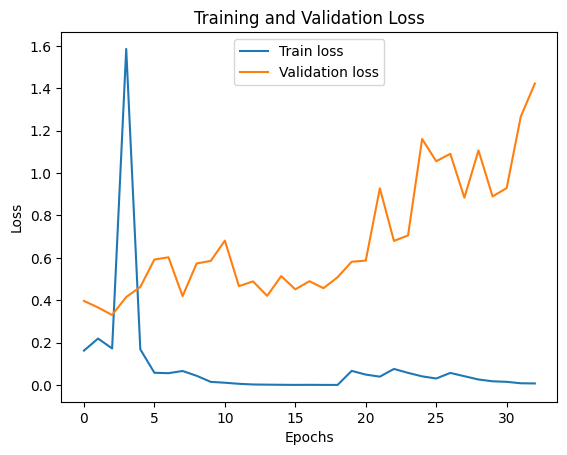

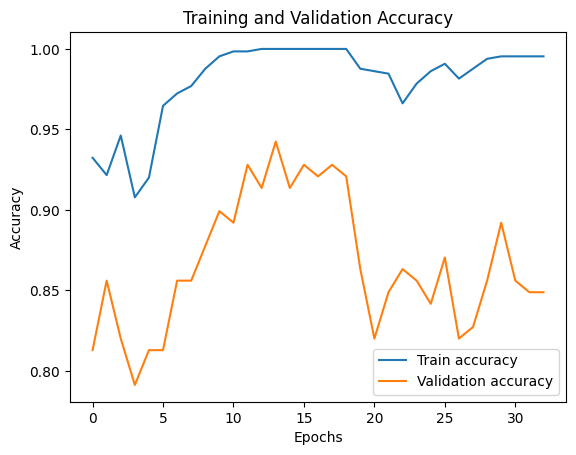

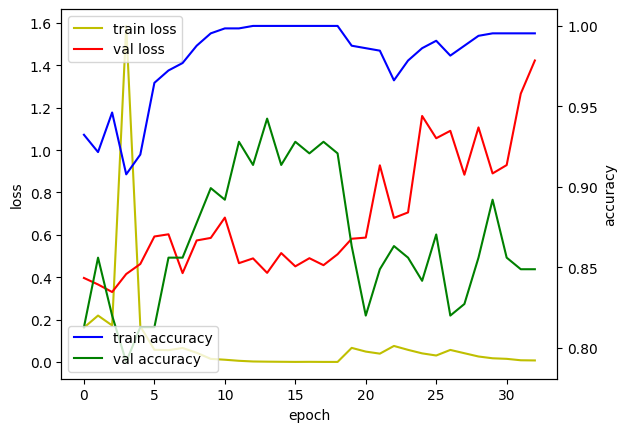

In [ ]:
#early stopping 도입
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# 모델 훈련
history = model.fit(train_images, train_labels,
                    batch_size=32, epochs=100,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping]
                    )

# 모델 평가
loss, accuracy = model.evaluate(test_images, test_labels)
print("테스트 데이터셋에서의 손실:", loss)
print("테스트 데이터셋에서의 정확도:", accuracy)

# 예측 수행
predictions = model.predict(test_images)
predictions = (predictions > 0.50).astype(int)  # 임계값 0.55 적용

# F1 스코어 계산
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 스코어:", f1)

#혼동 행렬 생성
cm = confusion_matrix(test_labels,  predictions)
# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 모델 훈련 후 시각화
plot_loss(history)
plot_accuracy(history)
plot_hist(history)

## 증강 후 원본 이미지

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 모델 생성
model = Sequential()

# Convolutional Layer와 Pooling Layer 추가
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fully Connected Layer 추가
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 구조 출력
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 26, 26, 128)      

Epoch 1/200
41/41 [==============================] - 2s 59ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 1.1509 - val_accuracy: 0.8885
Epoch 2/200
41/41 [==============================] - 2s 57ms/step - loss: 6.9040e-04 - accuracy: 1.0000 - val_loss: 1.0586 - val_accuracy: 0.8921
Epoch 3/200
41/41 [==============================] - 2s 53ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 1.1944 - val_accuracy: 0.8957
Epoch 4/200
41/41 [==============================] - 2s 52ms/step - loss: 0.0084 - accuracy: 0.9969 - val_loss: 1.9701 - val_accuracy: 0.8453
Epoch 5/200
41/41 [==============================] - 2s 48ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 1.1802 - val_accuracy: 0.8741
Epoch 6/200
41/41 [==============================] - 2s 48ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.1087 - val_accuracy: 0.8885
Epoch 7/200
41/41 [==============================] - 2s 56ms/step - loss: 3.3236e-04 - accuracy: 1.0000 - val_loss: 1.1073 - val_accuracy: 0.888

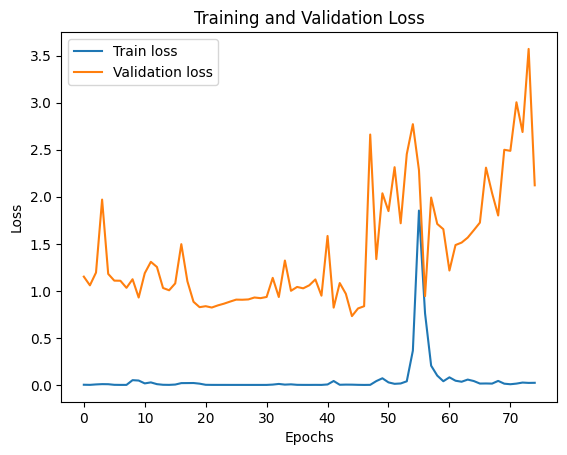

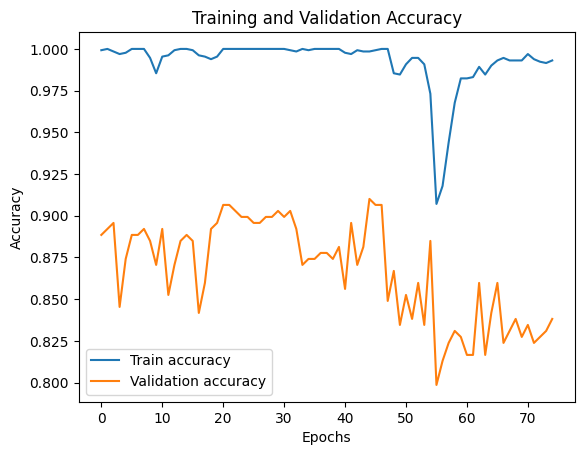

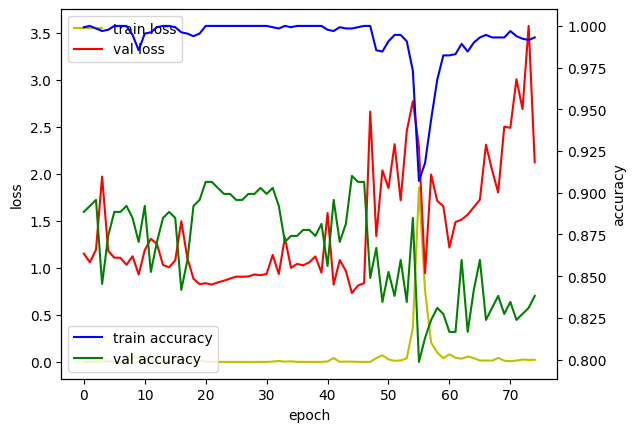

In [ ]:
# 증강 후 원본 이미지

# early stopping 도입
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# 모델 훈련
history = model.fit(train_aug_images, train_aug_labels,
                    batch_size=32, epochs=200,
                    validation_data=(val_aug_images, val_aug_labels),
                    callbacks=[early_stopping]
                    )

# 모델 평가
loss, accuracy = model.evaluate(test_aug_images, test_aug_labels)
print("테스트 데이터셋에서의 손실:", loss)
print("테스트 데이터셋에서의 정확도:", accuracy)

# 예측 수행
predictions = model.predict(test_aug_images)
predictions = (predictions > 0.50).astype(int)  # 임계값 0.55 적용

# F1 스코어 계산
precision = precision_score(test_aug_labels, predictions)
recall = recall_score(test_aug_labels, predictions)
f1 = f1_score(test_aug_labels, predictions)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 스코어:", f1)

#혼동 행렬 생성
cm = confusion_matrix(test_aug_labels,  predictions)
# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 모델 훈련 후 시각화
plot_loss(history)
plot_accuracy(history)
plot_hist(history)

---


# Canny Edge

In [ ]:

def preprocess_images_with_edge_detection(images):
    preprocessed_images = []
    for image in images:
        # 이미지를 흑백으로 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Canny 에지 검출을 통해 에지 감지
        edges = cv2.Canny(gray, threshold1=30, threshold2=100)
        # 에지 이미지를 원본 이미지와 결합하여 새로운 이미지 생성
        edge_image = np.dstack([edges] * 3)
        preprocessed_images.append(edge_image)
    return np.array(preprocessed_images)

# 이미지 전처리
train_images_preprocessed_with_edge = preprocess_images_with_edge_detection(train_images)
val_images_preprocessed_with_edge = preprocess_images_with_edge_detection(val_images)
test_images_preprocessed_with_edge = preprocess_images_with_edge_detection(test_images)

train_aug_images_preprocessed_with_edge = preprocess_images_with_edge_detection(train_aug_images)
val_aug_images_preprocessed_with_edge = preprocess_images_with_edge_detection(val_aug_images)
test_aug_images_preprocessed_with_edge = preprocess_images_with_edge_detection(test_aug_images)


## Build Model

### Original

Epoch 1/200
21/21 [==============================] - 5s 73ms/step - loss: 168.7132 - accuracy: 0.6759 - val_loss: 0.3524 - val_accuracy: 0.8705
Epoch 2/200
21/21 [==============================] - 1s 53ms/step - loss: 0.3126 - accuracy: 0.9017 - val_loss: 0.2029 - val_accuracy: 0.9065
Epoch 3/200
21/21 [==============================] - 1s 53ms/step - loss: 0.0916 - accuracy: 0.9708 - val_loss: 0.1940 - val_accuracy: 0.8993
Epoch 4/200
21/21 [==============================] - 1s 54ms/step - loss: 0.0365 - accuracy: 0.9923 - val_loss: 0.1757 - val_accuracy: 0.9209
Epoch 5/200
21/21 [==============================] - 1s 48ms/step - loss: 0.0232 - accuracy: 0.9939 - val_loss: 0.1798 - val_accuracy: 0.9281
Epoch 6/200
21/21 [==============================] - 1s 48ms/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.2355 - val_accuracy: 0.8849
Epoch 7/200
21/21 [==============================] - 1s 48ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.2325 - val_accuracy: 0.9209
Epoc

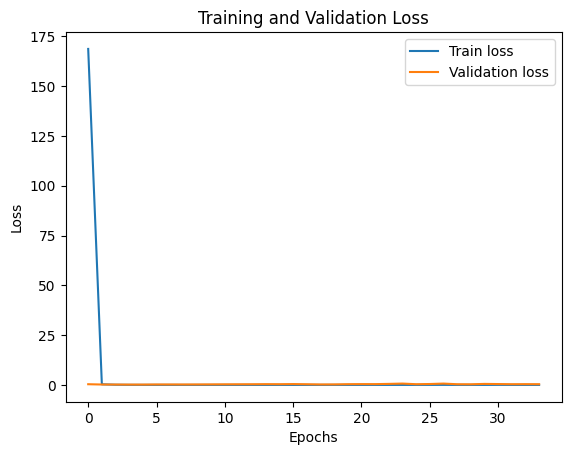

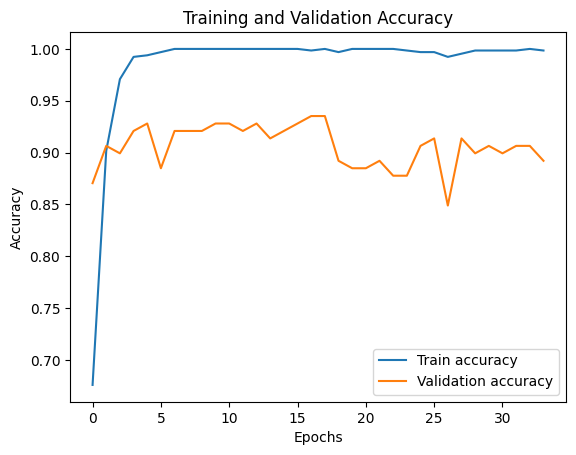

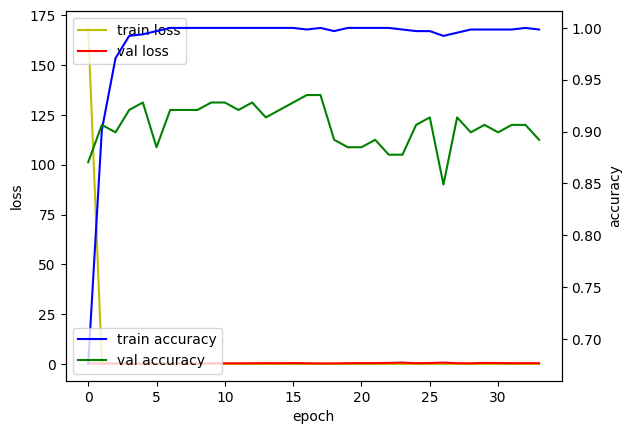

In [ ]:
# 모델 생성
model = Sequential()

# Convolutional Layer와 Pooling Layer 추가
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fully Connected Layer 추가
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early stopping 도입
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# 모델 훈련
history = model.fit(train_images_preprocessed_with_edge, train_labels,
                    batch_size=32, epochs=200,
                    validation_data=(val_images_preprocessed_with_edge, val_labels),
                    callbacks=[early_stopping])

# 모델 평가
loss, accuracy = model.evaluate(test_images_preprocessed_with_edge, test_labels)
print("테스트 데이터셋에서의 손실:", loss)
print("테스트 데이터셋에서의 정확도:", accuracy)

# 예측 수행
predictions = model.predict(test_images_preprocessed_with_edge)
predictions = (predictions > 0.50).astype(int)  # 임계값 0.55 적용

# 정밀도, 재현율, F1 스코어 계산
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 스코어:", f1)

#혼동 행렬 생성
cm = confusion_matrix(test_labels,  predictions)
# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 모델 훈련 후 시각화
plot_loss(history)
plot_accuracy(history)
plot_hist(history)

### Augmented

Epoch 1/200
21/21 [==============================] - 8s 130ms/step - loss: 177.9801 - accuracy: 0.6559 - val_loss: 0.5565 - val_accuracy: 0.8129
Epoch 2/200
21/21 [==============================] - 1s 59ms/step - loss: 0.6930 - accuracy: 0.8402 - val_loss: 0.4126 - val_accuracy: 0.8381
Epoch 3/200
21/21 [==============================] - 1s 62ms/step - loss: 0.2023 - accuracy: 0.9309 - val_loss: 0.2566 - val_accuracy: 0.8957
Epoch 4/200
21/21 [==============================] - 1s 60ms/step - loss: 0.0871 - accuracy: 0.9724 - val_loss: 0.2522 - val_accuracy: 0.9137
Epoch 5/200
21/21 [==============================] - 1s 62ms/step - loss: 0.0348 - accuracy: 0.9954 - val_loss: 0.2115 - val_accuracy: 0.9209
Epoch 6/200
21/21 [==============================] - 1s 56ms/step - loss: 0.0260 - accuracy: 0.9939 - val_loss: 0.1855 - val_accuracy: 0.9388
Epoch 7/200
21/21 [==============================] - 1s 50ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.2687 - val_accuracy: 0.9101
Epo

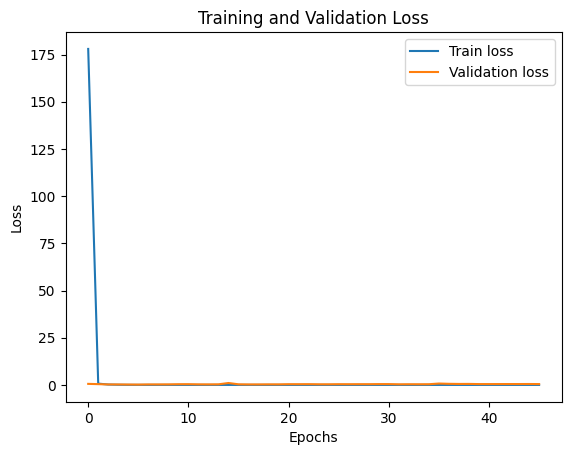

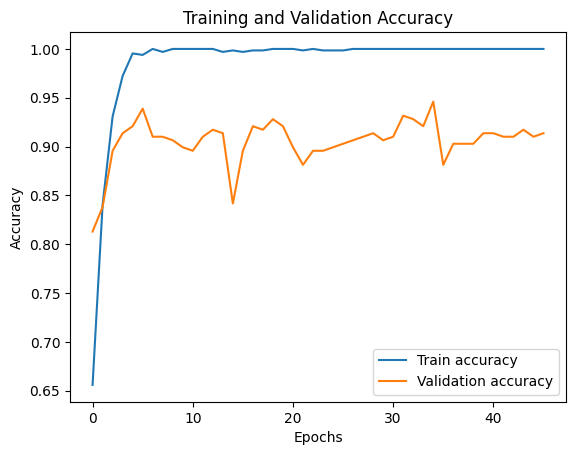

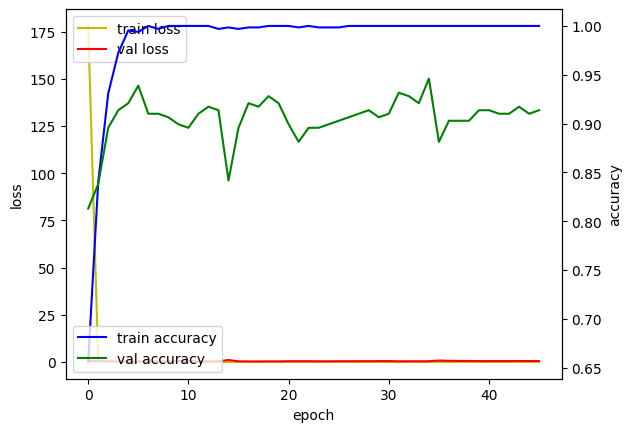

In [ ]:
# 모델 생성
model = Sequential()

# Convolutional Layer와 Pooling Layer 추가
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Fully Connected Layer 추가
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early stopping 도입
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# 모델 훈련
history = model.fit(train_images_preprocessed_with_edge, train_labels,
                    batch_size=32, epochs=200,
                    validation_data=(val_aug_images_preprocessed_with_edge, val_aug_labels),
                    callbacks=[early_stopping])

# 모델 평가
loss, accuracy = model.evaluate(test_aug_images_preprocessed_with_edge, test_aug_labels)
print("테스트 데이터셋에서의 손실:", loss)
print("테스트 데이터셋에서의 정확도:", accuracy)

# 예측 수행
predictions = model.predict(test_aug_images_preprocessed_with_edge)
predictions = (predictions > 0.50).astype(int)  # 임계값 0.55 적용

# 정밀도, 재현율, F1 스코어 계산
precision = precision_score(test_aug_labels, predictions)
recall = recall_score(test_aug_labels, predictions)
f1 = f1_score(test_aug_labels, predictions)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 스코어:", f1)

#혼동 행렬 생성
cm = confusion_matrix(test_aug_labels,  predictions)
# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 모델 훈련 후 시각화
plot_loss(history)
plot_accuracy(history)
plot_hist(history)

계속 Val Loss가 매우 낮게 나오는데, 그 이유가 동일한 영상에서 이미지를 추출한 경우에 이미지에 유사성이 많아서 그런 것 같음

## Pretrained